In [29]:
import os
import sys
import io
import cv2
import numpy as np
import pandas as pd
import boto3
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from time import gmtime, strftime
from IPython.display import clear_output

In [2]:
files = os.listdir('train')
dogs = [x for x in files if x.find('dog') != -1]
cats = [x for x in files if x.find('cat') != -1]
targets = [dogs, cats]

### Dataset:
**Link:**

There are 12,500 images of each species contained. Images are larger than thumbnails and are of a variety of breeds. Angles, colors, position are incidental to each photograph.

In [3]:
# Helper Functions
def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

def generate_sift(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

In [4]:
#img = cv2.imread('train/' + dogs[1])
#img = to_gray(img)
#kp1, desc1 = generate_sift(img)

In [5]:
#print("desc_0:", len(desc))
#print("desc_1:", len(desc1))

In [22]:
#len(np.vstack((desc,desc1)))

574

### Extracting keypoint descriptors from images

In [6]:
def extract_desc(file, path='train/'):
    
    img = cv2.imread(path + file)
    img = to_gray(img)
    
    kp, desc = generate_sift(img)
    
    num_desc = desc.shape[0]
    images = np.full((num_desc,1), file)
    
    return images, kp, desc

In [7]:
def run_extract(file_list):
    
    num_of_files = len(file_list)
    i = 1
    desc_total = None
    kp_total = None
    img_total = None
    
    for file in file_list:
        
        # Extract all SIFT keypoints and descriptors
        images, kp, desc = extract_desc(file)
        
        if i == 1:
            kp_total = kp
            desc_total = desc
            img_total = images
            clear_output(wait=True)
            print(i, "/", num_of_files, "completed")
            i = i + 1
            continue
            
        else:
            kp_total = np.append(kp_total, kp)
            desc_total = np.vstack((desc_total, desc))
            img_total = np.vstack((img_total, images))
            clear_output(wait=True)
            print(i, "/", num_of_files, "completed")
            i = i + 1
    
    
    return img_total, kp_total, desc_total

In [8]:
dog_img, dog_kp, dog_desc = run_extract(dogs[:500])

500 / 500 completed


In [9]:
cat_img, cat_kp, cat_desc = run_extract(cats[:500])

500 / 500 completed


In [10]:
dog_kp[0].angle

129.7286376953125

In [11]:
cat_img.shape

(333474, 1)

## Save Data
Comment out if not needed


In [14]:
# Save Cats
np.save('data/20190120-sampledesc-cats', cat_desc)
np.save('data/20190120-img-cats', cat_img)

# Save Dogs
np.save('data/20190120-sampledesc-dogs', dog_desc)
#np.save('20190120-kmeans-samplelabels-dogs', dog_labels)
#np.save('20190120-kmeans-samplecenters-dogs', centers)
np.save('data/20190120-img-dogs', dog_img)

## K-Means Clustering

After using the cv2 method below, it was far too slow on my macbook, engineering laptop, and lab desktop computer. I opted to use AWS Sagemaker for clustering.

In [ ]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
#criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set flags (Just to avoid line break in the code)
#flags = cv2.KMEANS_RANDOM_CENTERS

# Apply KMeans
#compactness, dog_lab, dog_cen = cv2.kmeans(dog_desc ,1000,None,criteria,10,flags)

### AWS SageMaker

Create an S3 instance and load data

In [65]:
# S3 bucket
#bucket = 'cats-vs-dogs-descriptors' # '<user-data-bucket>' # replace with your bucket name'
bucket = 'sagemaker-catsvsdogs-east-1'
prefix = 'sagemaker/DEMO-kmeans'

In [66]:
def get_s3_data(filename):
    s3 = boto3.resource('s3')
    s3.Bucket('cats-vs-dogs-descriptors').download_file(filename, '.desc.npy')
    a = np.load('.desc.npy')
    return a

In [23]:
FILE = 'sampledesc-dogs.npy'
dog_desc = get_s3_data(FILE)

In [24]:
dog_desc.shape

(436862, 128)

Since the data load was successfull, the next step is to try out a plain vanilla configuration of AWS SageMaker (K-Means) with 1000 clusters. This will give me feel for how much time is saved by using AWS and also if any cost in incurred. 

Further efforts could focus around tuning the hyperparameters and building a more robust dictionary (i.e. more images and descriptors).

In [46]:
# SageMaker k-means ECR images ARNs 
images = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/kmeans:latest',
          'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/kmeans:latest',
          'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/kmeans:latest',
          'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/kmeans:latest'}
image = images[boto3.Session().region_name]

### Convert data to IO format for SageMaker

In [67]:
def write_s3_data(bucket, prefix, channel, X):
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, X.astype('float32'))
    buf.seek(0)
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, channel + '.data')).upload_fileobj(buf)

In [68]:
write_s3_data(bucket, prefix, 'train', dog_desc)

### SageMaker Low-Level SDK method

In [69]:
role = 'arn:aws:iam::536197384257:role/service-role/AmazonSageMaker-ExecutionRole-20190129T171919'

In [70]:
job_name = 'kmeans-lowlevel-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

Training job kmeans-lowlevel-2019-01-30-08-36-33


In [73]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image = get_image_uri(boto3.Session().region_name, 'kmeans')

output_location = 's3://{}/kmeans_lowlevel_example/output'.format(bucket)
print('training artifacts will be uploaded to: {}'.format(output_location))

k = '1000'
features = '128'
create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": output_location
    },
    "ResourceConfig": {
        "InstanceCount": 2,
        "InstanceType": "ml.c4.8xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "k": k,
        "feature_dim": features,
        "mini_batch_size": "500"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train.data".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ]
}

sagemaker = boto3.client('sagemaker')

sagemaker.create_training_job(**create_training_params)

status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

try:
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
finally:
    status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("Training job ended with status: " + status)
    if status == 'Failed':
        message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Training job failed')

training artifacts will be uploaded to: s3://sagemaker-catsvsdogs-east-1/kmeans_lowlevel_example/output
InProgress
Training job ended with status: Completed


### Inspect SageMaker output

### Cats

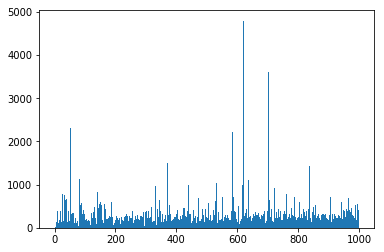

((array([6.910e+02, 1.000e+00, 2.130e+02, 1.300e+01, 7.000e+02, 6.440e+02,
         1.350e+02, 6.000e+00, 5.000e+00, 3.860e+02, 1.400e+01, 6.000e+01,
         3.730e+02, 1.210e+02, 2.930e+02, 1.070e+02, 1.750e+02, 2.350e+02,
         1.020e+02, 3.840e+02, 1.190e+02, 3.510e+02, 1.430e+02, 5.600e+02,
         1.350e+02, 3.080e+02, 7.780e+02, 7.500e+01, 2.130e+02, 1.500e+02,
         1.800e+01, 1.480e+02, 7.710e+02, 1.070e+02, 1.910e+02, 6.410e+02,
         3.310e+02, 1.290e+02, 4.380e+02, 6.660e+02, 2.409e+03, 2.120e+02,
         1.330e+02, 8.100e+01, 1.780e+02, 3.890e+02, 1.410e+02, 2.630e+02,
         1.790e+02, 1.620e+02, 1.300e+02, 1.400e+02, 2.318e+03, 2.060e+02,
         2.210e+02, 3.280e+02, 1.080e+02, 1.380e+02, 3.380e+02, 1.170e+02,
         2.290e+02, 2.016e+03, 3.450e+02, 1.530e+02, 3.630e+02, 1.190e+02,
         9.000e+01, 1.100e+02, 2.230e+02, 1.490e+02, 2.100e+02, 1.240e+02,
         1.030e+02, 1.840e+02, 7.710e+02, 1.580e+02, 3.070e+02, 1.820e+02,
         4.600e+01, 2.040

In [10]:
from matplotlib import pyplot as plt
plt.hist(labels, bins=1000),plt.show()

In [83]:
cdf = pd.DataFrame(labels, columns=["desc_cats"])
top_500_cats = cdf["desc_cats"].value_counts().nlargest(500).reset_index()['index']


In [95]:
cat_centers = centers[top_500_cats]

### Dogs

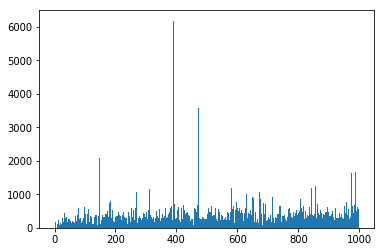

((array([2.080e+02, 1.336e+03, 1.500e+01, 1.760e+02, 1.860e+02, 6.300e+01,
         2.000e+00, 1.002e+03, 1.720e+02, 1.160e+02, 1.150e+02, 1.550e+02,
         1.240e+02, 2.450e+02, 1.510e+02, 1.130e+02, 7.200e+01, 2.420e+02,
         3.730e+02, 1.330e+02, 2.000e+01, 1.730e+02, 1.120e+02, 2.190e+02,
         1.600e+02, 5.140e+02, 3.010e+02, 8.000e+01, 2.690e+02, 1.720e+02,
         3.940e+02, 4.290e+02, 4.330e+02, 2.000e+02, 2.650e+02, 2.860e+02,
         2.640e+02, 8.200e+01, 8.700e+01, 3.240e+02, 3.980e+02, 1.490e+02,
         1.600e+02, 2.440e+02, 1.980e+02, 2.500e+02, 7.500e+01, 3.400e+02,
         5.810e+02, 2.480e+02, 1.380e+02, 1.890e+02, 1.980e+02, 3.900e+02,
         3.310e+02, 1.370e+02, 6.230e+02, 2.736e+03, 2.040e+02, 4.960e+02,
         4.220e+02, 2.580e+02, 1.640e+02, 1.390e+02, 3.420e+02, 1.300e+02,
         3.900e+02, 8.100e+01, 3.560e+02, 1.980e+02, 1.770e+02, 3.550e+02,
         2.110e+02, 3.080e+02, 2.470e+02, 3.870e+02, 3.570e+02, 1.590e+02,
         5.890e+02, 2.340

In [100]:
from matplotlib import pyplot as plt
plt.hist(labels, bins=1000),plt.show()

The labels with extremely high occurances should be investigated. Feature reduction should take the most dog and cat features that are most common to each target and most dissimiliar to other targets.

In [245]:
# Read in previously computed cluster data for dogs
dog_centers = np.load('20190120-kmeans-samplecenters-dogs.npy')
dog_labels = np.load('20190120-kmeans-samplelabels-dogs.npy')

In [251]:
# Get top 500 most frequent dog labels & their centers
ddf = pd.DataFrame(labels, columns=["desc_dogs"])
top_500_ix = ddf["desc_dogs"].value_counts().nlargest(500).reset_index()['index']

### Filter descriptors 

I opted to reduce the labels to the 500 most frequent labels. This is just a starting place; more work will need to continue here.

In [253]:
top_500_ix.head()

0    620
1    702
2     40
3    649
4     52
Name: index, dtype: int64

In [257]:
desc_ix = np.where(np.in1d(dog_labels, top_500_ix))[0]

In [260]:
dog_desc[desc_ix].shape

(216798, 128)

In [261]:
desc_filter = dog_desc[desc_ix]
lab_filter = dog_labels[desc_ix]

In [262]:
cen_fiter = dog_centers[top_500_ix]

### Predict labels for other categories

In [266]:
# Load precomputed cat descriptors
cat_descriptors = np.load('20190120-sampledesc-cats.npy')

In [267]:
def predict(desc, centers, labels):
    pred_label = np.empty(0)
    pred_dist = np.empty(0)
    for d in desc:
        min_distance = None
        min_lab = None
        for lab in labels:
            current_distance = np.linalg.norm(d - centers[lab])
            if min_distance is None:
                min_distance = current_distance
                min_label = current_label
            if current_distance < min_distance:
                min_distance = current_distance
                min_label = current_label
                
        # Store all predicted labels in 1-d array
        pred_label = np.append(pred_label, min_label)
        pred_dist = np.append(pred_dist, min_dist)
    
    return pred_label, pred_dist

In [271]:
cat_pred, pred_dist = predict(cat_descriptors, dog_centers, top_500_ix)

KeyboardInterrupt: 

### Build the Dataset
For each image we will need to get the pre-comupted descriptors and use the cluster centers to determine best label for each label. The input to a function should be an image number to query the descriptors and the function will translate the image to a 1-d vector with counts for each label.

In [243]:
def add_row(cluster_label, image, desc, centers):
    unique_labels = np.unique(cluster_label)
    unique_labels = np.sort(unique_labels, axis=None)
    unique_images = np.unique(image)
    
    for img in unique_images:
        index = np.where(np.in1d(image, img))[0]
        img_descriptors = desc[index]
        
        img_label = np.empty(0)  
        #img_label_count = np.empty(0)
        
        for d in img_descriptors:
            min_distance = None
            min_lab = None
            for lab in unique_labels:
                current_distance = np.linalg.norm(d - dog_centers[lab])
                if min_distance is None:
                    min_distance = current_distance
                    min_label = current_label
                if current_distance < min_distance:
                    min_distance = current_distance
                    min_label = current_label
            
            # Store all predicted labels in 1-d array
            img_label = np.append(img_label, min_label)
        
        # Group by
        #img_label = pd.Series(img_label)
        #img_label_counts = img_label.value_counts()
        # Left join to labels to generate 'zero' columns
        
        # Transpose
        # Insert to dataframe

In [244]:
len(dog_labels)
#add_row(dog_labels)

436862

In [240]:
a = np.ravel(labels)

In [241]:
a = pd.Series(a)

In [242]:
a.value_counts()

620    4797
702    3620
40     2409
649    2353
52     2318
304    2292
584    2224
61     2016
83     1902
266    1883
212    1635
427    1615
371    1510
845    1482
837    1421
763    1326
286    1303
81     1135
637    1104
484    1076
744    1052
395    1043
724    1037
532    1031
194     992
440     990
678     990
617     984
331     967
198     938
       ... 
197      93
211      93
109      92
66       90
86       89
216      84
169      81
43       81
185      80
607      79
137      78
27       75
118      69
334      68
437      65
135      65
11       60
193      60
120      60
78       46
295      43
441      28
30       18
10       14
3        13
399      10
7         6
8         5
1         1
103       1
Length: 1000, dtype: int64

In [232]:

labs = None

for img in np.unique(dog_img):
    
    index = np.where(np.in1d(dog_img, img))[0]
    d = dog_desc[index]
    num_desc = d.shape[0]
    labs = np.empty(0)
    
    min_distance = None
    min_lab = None
    
    for descriptor in d:
        
        for current_label in range(0,999):
            current_distance = np.linalg.norm(descriptor - dog_centers[current_label])

            if min_distance is None:
                min_distance = current_distance
                min_label = current_label
            if current_distance < min_distance:
                min_distance = current_distance
                min_label = current_label
        
        labs = np.append(labs, min_label)
        #transpose, fill with zeros for missing labels
        # write to pandas dataframe row
        
    ## function ##
    


In [234]:
np.arange(1,)

### Loop through new descriptors and assign labels

In [181]:
predicted_labels = np.empty(0)
predicted_distance = np.empty(0)

for desc in desc_total[0:3]:
    
    min_distance = None
    min_label = None
    current_distance = None
    current_label = None

    for lab in range(0,999):
        
        current_distance = np.linalg.norm(cent - x)
        dist(desc, centers[lab])
        
        if min_distance is None:
            min_distance = current_distance
            min_label = lab
        if current_distance < min_distance:
            min_distance = current_distance
            min_label = lab
            
    predicted_labels = np.append(predicted_labels, min_label)
    predicted_distance = np.append(predicted_distance, min_distance)

In [182]:
predicted_distance

array([124.51062012, 200.84196472, 119.63799286])

# Remaining Tasks

- Use %%timeit
- Try with 5000 photos of each target, decrease as needed
- Test on 500/each
- Create SIFT features on entire set
- Cluster on training set
- Create dictionary
- Transform to dictionary feature set
- SVM on dictionary transform
- Transform testing set to dictionary
- Predict w/ trained SVM

## Packages Needed:
- **pandas** for using scikit
- **scikit-learn** for kmeans & SVM

## DAN2 Research:
- How can we reduce the dictionary?
- Should we pre-process images more than grey-scaling? (e.g., HOG, edge detectiony, feature detection)
    - explore opencv4 for latest offerings

### Addtional Info
http://aishack.in/tutorials/sift-scale-invariant-feature-transform-introduction/